# ANALYZE BIOMODELS SUBNETS

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tellurium as te

import pySubnetSB.constants as cn
from pySubnetSB.network import Network

# Data Preparation

In [2]:
PATH = os.path.join(cn.PROJECT_DIR, "biomodels_subnets.csv")
df = pd.read_csv(PATH)
df.head()

,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair
0,BIOMD0000000191,BIOMD0000000634,NaN,NaN,NaN,NaN
1,BIOMD0000000191,BIOMD0000000152,NaN,NaN,NaN,NaN
2,BIOMD0000000191,BIOMD0000000146,NaN,NaN,NaN,NaN
3,BIOMD0000000191,BIOMD0000000608,NaN,NaN,NaN,NaN
4,BIOMD0000000191,BIOMD0000000807,NaN,NaN,NaN,NaN


In [16]:
REFERENCE_NAMES = (df['reference_name'].unique())
REFERENCE_NAMES.sort()
NUM_REFERENCE = len(REFERENCE_NAMES)
TARGET_NAMES = (df['target_name'].unique())
TARGET_NAMES.sort()
NUM_TARGET = len(TARGET_NAMES)
NUM_REFERENCE, NUM_TARGET

(186, 492)

In [4]:
SUBNET_DF = df[df['num_assignment_pair'] > 0]
SUBNET_DF = SUBNET_DF.copy()
SUBNET_DF = SUBNET_DF.reset_index()
SUBNET_DF.head()

,index,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair
0,1131,BIOMD0000000224,BIOMD0000000939,"BIOMD0000000224: 4 species, 6 reactions\n JCh...","BIOMD0000000224_BIOMD0000000939: 4 species, 6 ...","{""species_names"": {""CaI"": ""APC_Ccdc20_inactive...",36.0
1,1195,BIOMD0000000224,BIOMD0000000269,"BIOMD0000000224: 4 species, 6 reactions\n JCh...","BIOMD0000000224_BIOMD0000000269: 4 species, 6 ...","{""species_names"": {""CaI"": ""Re_star"", ""IP3"": ""P...",36.0
2,1205,BIOMD0000000224,BIOMD0000000056,"BIOMD0000000224: 4 species, 6 reactions\n JCh...","BIOMD0000000224_BIOMD0000000056: 4 species, 6 ...","{""species_names"": {""CaI"": ""IEP"", ""IP3"": ""CLN2""...",120.0
3,1326,BIOMD0000000224,BIOMD0000000704,"BIOMD0000000224: 4 species, 6 reactions\n JCh...","BIOMD0000000224_BIOMD0000000704: 4 species, 6 ...","{""species_names"": {""CaI"": ""Chk1P"", ""IP3"": ""p53...",4.0
4,1340,BIOMD0000000224,BIOMD0000000856,"BIOMD0000000224: 4 species, 6 reactions\n JCh...","BIOMD0000000224_BIOMD0000000856: 4 species, 6 ...","{""species_names"": {""CaI"": ""SBFu"", ""IP3"": ""CLN""...",4.0


# Helpers

In [5]:
def makeAntimony(model_name:str, is_reference:bool=True, is_roadrunner_loadable:bool=False):
    """
    Transforms the string in a "network" cell into an antimony model
    """
    if is_reference:
        name_col = 'reference_name'
        network_col = 'reference_network'
    else:
        name_col = 'target_name'
        network_col = 'induced_network'
    models =  SUBNET_DF[SUBNET_DF[name_col] == model_name][network_col].values
    if len(models) == 0:
        return None
    model = models[0]
    if is_roadrunner_loadable:
        pos = model.index('tions\n')
        model = model[pos+7:]
        model = model.replace('\n', ';1\n')
        model += ";1;"
    return model

# TESTS
model = makeAntimony('BIOMD0000000224', is_roadrunner_loadable=True)
rr = te.loada(model)
model = makeAntimony('BIOMD0000000030')
assert(model is None)
print("OK!")

OK!


In [6]:
def extractBiomodelNum(stg:str)->int:
    """
    Extracts the number from the biomodels name.
    """
    substg = stg[5:]
    pos = np.min([n if c != '0' else 1000 for n, c in enumerate(substg)])
    result = int(substg[pos:])
    return result

# TESTS
num = extractBiomodelNum('BIOMD0000000030')
assert(num == 30)
num = extractBiomodelNum('BIOMD0000002030')
assert(num == 2030)
print("OK!")

OK!


# Analysis

Text(0.5, 1.0, 'Strong Identity Subnets in BioModels. Reference model <= 10 Reactions.')

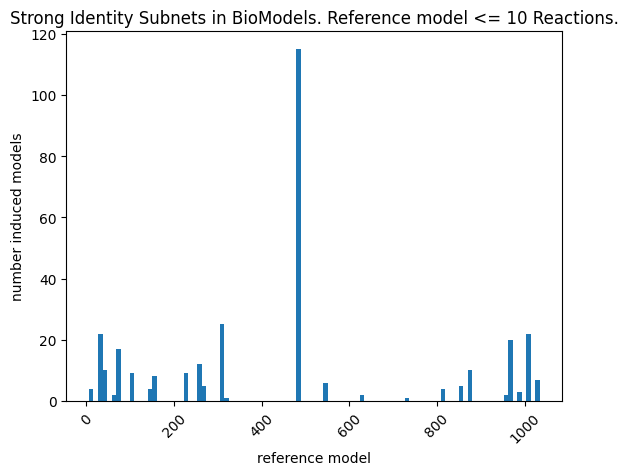

In [14]:
# Number of targets
xvals = [extractBiomodelNum(s) for s in SUBNET_DF['reference_name']]
_ = plt.hist(xvals, bins=100)
_ = plt.xticks(rotation=45)
plt.xlabel('reference model')
plt.ylabel('number induced models')
plt.title('Strong Identity Subnets in BioModels. Reference model <= 10 Reactions.')

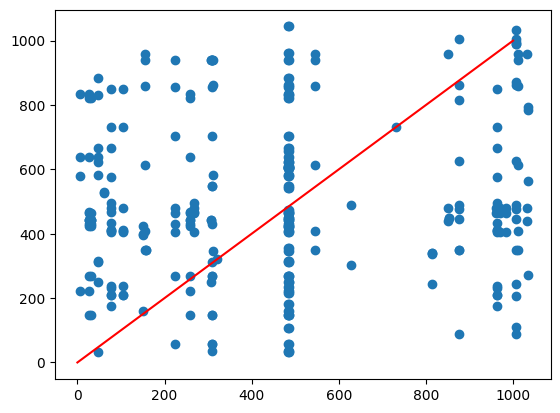

In [26]:
# Scatter plot of subnets
xvals = [extractBiomodelNum(m) for m in SUBNET_DF['reference_name']]
yvals = [extractBiomodelNum(m) for m in SUBNET_DF['target_name']]
plt.scatter(xvals, yvals)
#plt.xlim([0, 300])
#plt.ylim([0, 300])
plt.plot([0,1000], [0, 1000], c='red')

Above the red line are target odels that embed an existing reference model. Below the red line indicate common motif without reuse. The dots below indicate opportunities for reuse.

In [9]:
SUBNET_DF.to_csv("subnet.csv")

In [17]:
# Print all of the reference models that appear in targets
for name in REFERENCE_NAMES:
    result = makeAntimony(name)
    if result is not None:
        print(result + '\n\n')

BIOMD0000000006: 4 species, 3 reactions
  Reaction1: EmptySet -> z
  Reaction2: u -> EmptySet
  Reaction3: z -> u


BIOMD0000000027: 5 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000031: 6 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000047: 2 species, 3 reactions
  Jch: CaER -> Ca_Cyt
  Jleak: CaER -> Ca_Cyt
  Jpump: Ca_Cyt -> CaER


BIOMD0000000060: 4 species, 3 reactions
  Closed_state_1: Po1 -> Pc1
  Open_state_2: Po1 -> Po2
  Closed_State_2: Po1 -> Pc2


BIOMD0000000076: 3 species, 2 reactions
  Gpd_p: DHAP -> G3P
  Gpp_p: G3P -> Gly


BIOMD0000000104: 6 species, 2 reactions
  reaction_0: species_0 -> species_1
  reaction_1: species_1 -> species_4


BIOMD0000000150: 4 species, 2 reactions
  Binding: CyclinA + Cdk2 -> CDK2cycA
  Activation: CDK2cycA -> CDK2cycA_star_


BIOMD0000000156: 3 species, 5 reactions
  R1:  -> x
  R3: x -> 
  R4:  -> y0
  R5: y0 -> y
  R6: y -> 


BIOMD0000000157:

In [11]:
REFERENCE_NAMES


array(['BIOMD0000000191', 'BIOMD0000000387', 'BIOMD0000000224',
       'BIOMD0000000556', 'BIOMD0000000026', 'BIOMD0000000967',
       'BIOMD0000000966', 'BIOMD0000000755', 'BIOMD0000000027',
       'BIOMD0000000231', 'BIOMD0000000225', 'BIOMD0000000386',
       'BIOMD0000000812', 'BIOMD0000000184', 'BIOMD0000000609',
       'BIOMD0000000186', 'BIOMD0000000353', 'BIOMD0000000384',
       'BIOMD0000000390', 'BIOMD0000000233', 'BIOMD0000000031',
       'BIOMD0000000970', 'BIOMD0000000965', 'BIOMD0000000385',
       'BIOMD0000000408', 'BIOMD0000000805', 'BIOMD0000000193',
       'BIOMD0000000187', 'BIOMD0000000178', 'BIOMD0000000150',
       'BIOMD0000000168', 'BIOMD0000000197', 'BIOMD0000001048',
       'BIOMD0000000236', 'BIOMD0000000785', 'BIOMD0000000948',
       'BIOMD0000000974', 'BIOMD0000000545', 'BIOMD0000000380',
       'BIOMD0000000357', 'BIOMD0000000814', 'BIOMD0000000157',
       'BIOMD0000000194', 'BIOMD0000000962', 'BIOMD0000000976',
       'BIOMD0000000963', 'BIOMD00000000

# Notes

1. Look for targets with multiple reference submodels.
2. Find interesting plots for paper
3. Do Weak and Strong identities
4. Scatter plot of reference (x) vs. target (y) ordered by BioModels number. Horizontal indicates subnets for same target. Vertical is targets for same reference.